## Notebook AIM: Validate different models trained on different datasets

##### Initialization

In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 13.5 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
%matplotlib inline

In [3]:
DISEASE_PRED_PATH="/content/drive/MyDrive/AIDocAssist/Disease_predictor"

In [108]:
original_data = pd.read_csv(DISEASE_PRED_PATH+"/Prepared_Data2.csv")
unduplicated_data = pd.read_csv(DISEASE_PRED_PATH+"/Prepared_Data.csv")
generated_data = pd.read_csv(DISEASE_PRED_PATH+"/Prepared_Datav2.csv")

In [109]:
original_data.drop(columns="prognosis", inplace=True)
original_data.drop(columns="fluid_overload.1", inplace=True)
unduplicated_data.drop(columns="prognosis", inplace=True)

### Seeing the correlations between Original Data, Original Unduplicated Data and Generated Data

- Original Dataset - 4920 cases
- Unduplicated Dataset - removed duplicates from Original Dataset: almost 300 cases
- Generated Dataset - roughly 2,10,000 cases generated using powerful symptoms

#### Original Data

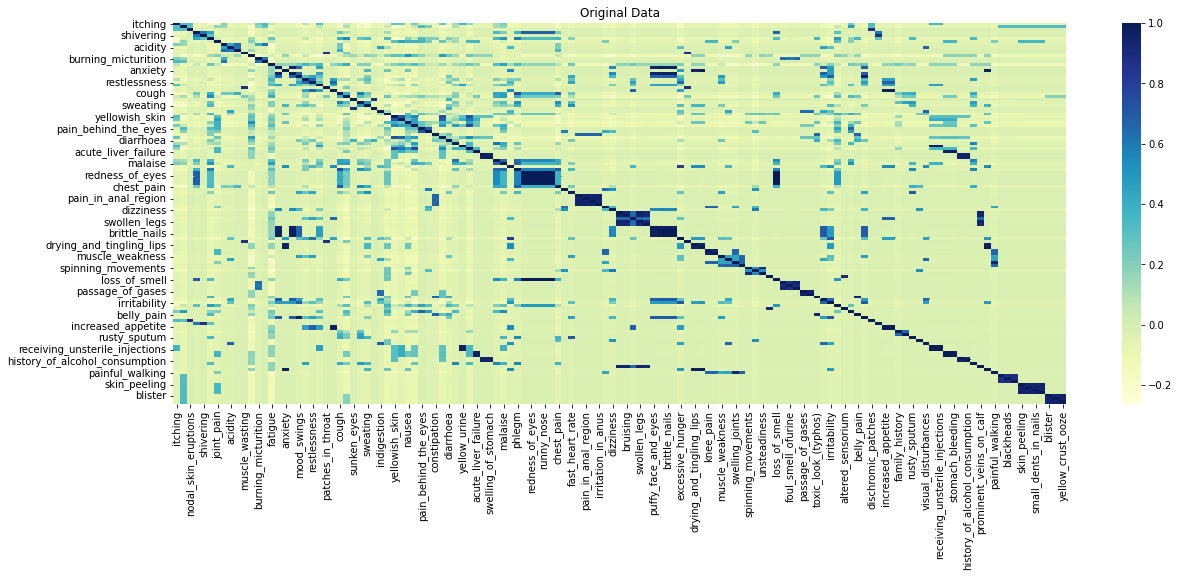

In [6]:
fig, ax = plt.subplots(figsize=(20,7)) 
plt.title("Original Data")
sns.heatmap(original_data.iloc[:,:-1].corr(),  cmap="YlGnBu")

#### Unduplicated Original Data

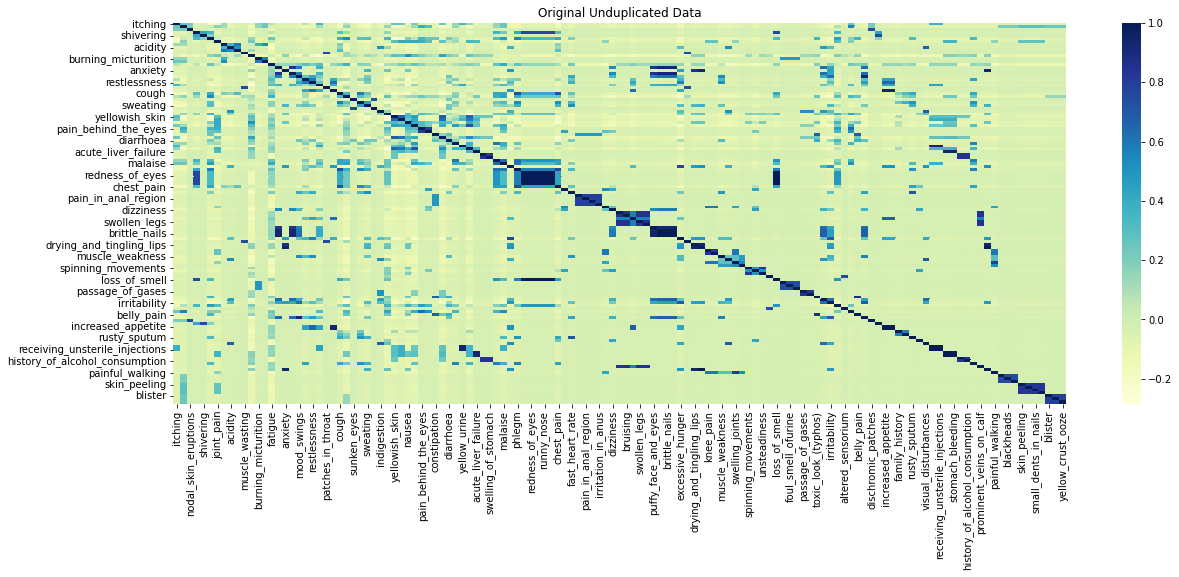

In [7]:
fig, ax = plt.subplots(figsize=(20,7)) 
plt.title("Original Unduplicated Data")
sns.heatmap(unduplicated_data.iloc[:,:-1].corr(),  cmap="YlGnBu")

#### Generated Data

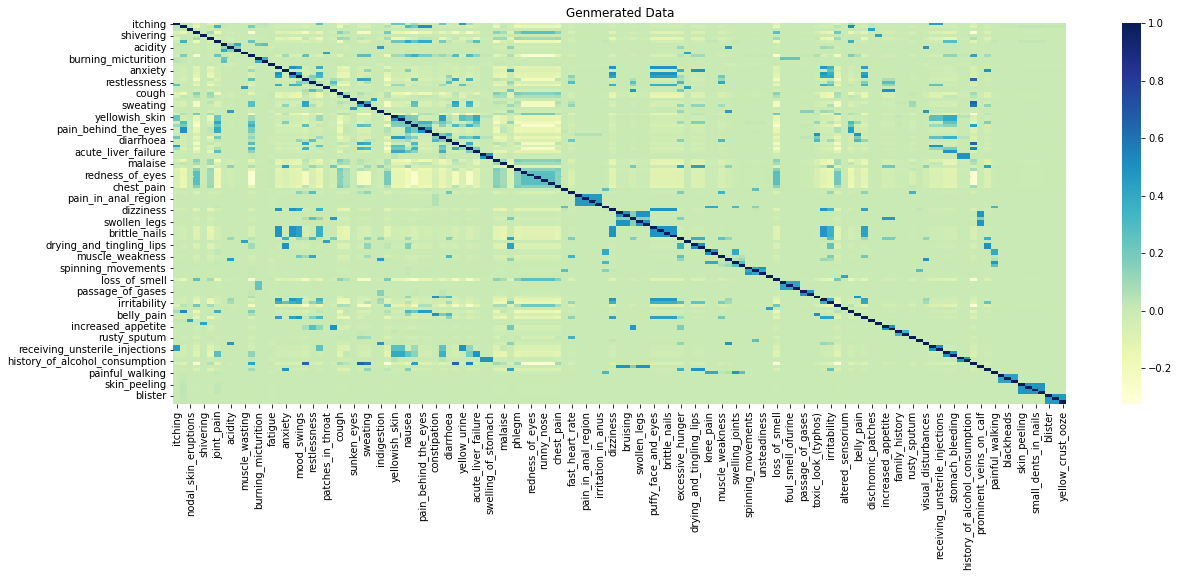

In [110]:
fig, ax = plt.subplots(figsize=(20,7)) 
plt.title("Generated Data")
sns.heatmap(generated_data.iloc[:,:-1].corr(),  cmap="YlGnBu")

### Training Models with these 3 Datasets

#### Original Data

In [9]:
X = original_data.drop(columns="disease")
y = original_data['disease']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 1)

In [10]:
X_train.shape

(3936, 131)

In [11]:
X_test.shape

(984, 131)

In [12]:
rfc_original=RandomForestClassifier()
cross_val_score(rfc_original, X_train, y_train, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
rfc_original = RandomForestClassifier()
rfc_original.fit(X_train, y_train)
y_pred = rfc_original.predict(X_test)
accuracy_score(y_pred, y_test)

1.0

In [14]:
rfc_original_explainer= shap.explainers.Tree(rfc_original, data=X_train)
# rfc_original_shap = rfc_original_explainer.shap_values(X_test[1:])

#### Unduplicated Original Data

In [15]:
X = unduplicated_data.drop(columns="disease")
y = unduplicated_data['disease']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 1)

In [16]:
X_train.shape

(243, 131)

In [17]:
X_test.shape

(61, 131)

In [18]:
rfc_undup=RandomForestClassifier()
cross_val_score(rfc_undup, X_train, y_train, cv=5)

The least populated class in y has only 2 members, which is less than n_splits=5.


array([1., 1., 1., 1., 1.])

In [19]:
rfc_undup = RandomForestClassifier()
rfc_undup.fit(X_train, y_train)
y_pred = rfc_undup.predict(X_test)
accuracy_score(y_pred, y_test)

1.0

In [20]:
rfc_undup_explainer= shap.explainers.Tree(rfc_undup, data=X_train)
# rfc_undup_shap = rfc_undup_explainer.shap_values(X_test)

#### Generated Data

In [111]:
X = generated_data.drop(columns="disease")
y = generated_data['disease']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 1)

In [112]:
X_train.shape

(168139, 131)

In [113]:
X_test.shape

(42035, 131)

In [114]:
rfc_generated=RandomForestClassifier()
cross_val_score(rfc_generated, X_train, y_train, cv=5)

array([0.99931605, 0.99884025, 0.99916736, 0.99931605, 0.99889969])

In [115]:
rfc_generated = RandomForestClassifier()
rfc_generated.fit(X_train, y_train)
y_pred = rfc_generated.predict(X_test)
accuracy_score(y_pred, y_test)

0.9990008326394672

In [116]:
rfc_generated_explainer= shap.explainers.Tree(rfc_generated, data=X_train)
# rfc_generated_shap = rfc_generated_explainer.shap_values(X_test, approximate=True)

### Validating models with SHAP values

#### Sampling from Original Dataset

In [117]:
test_sample = unduplicated_data.drop_duplicates(subset="disease").drop(columns="disease")
test_classes =  unduplicated_data.drop_duplicates(subset="disease")["disease"].values

In [118]:
rfc_original_shap = rfc_original_explainer.shap_values(test_sample)
rfc_undup_shap = rfc_undup_explainer.shap_values(test_sample)
rfc_generated_shap = rfc_generated_explainer.shap_values(test_sample )

 99%|===================| 1661/1681 [01:21<00:00]       

In [119]:
def draw_force_plot(model,model_explainer, model_shap, X_test, i):
  
  predicted_class = model.predict(X_test.iloc[i:i+1,:])[0]
  class_index = np.where(model.classes_==predicted_class)[0][0]
  return shap.plots.force(model_explainer.expected_value[class_index], model_shap[class_index][i], X_test.iloc[i,:], out_names=predicted_class, matplotlib=True, contribution_threshold=0.03,text_rotation=45)

In [120]:
def compare_force_plots(sample_number):
  print("="*30+" "+test_classes[sample_number]+" "+"="*30)
  print("Model trained on Original Data")
  draw_force_plot(rfc_original, rfc_original_explainer, rfc_original_shap, test_sample, sample_number)
  print("Model trained on Unduplicated Data")
  draw_force_plot(rfc_undup, rfc_undup_explainer, rfc_undup_shap, test_sample, sample_number)
  print("Model trained on Generated Data")
  draw_force_plot(rfc_generated, rfc_generated_explainer, rfc_generated_shap, test_sample, sample_number)

#### Comparing Force Plots of these three models for some samples 

============================== Fungal infection ==============================
Model trained on Original Data


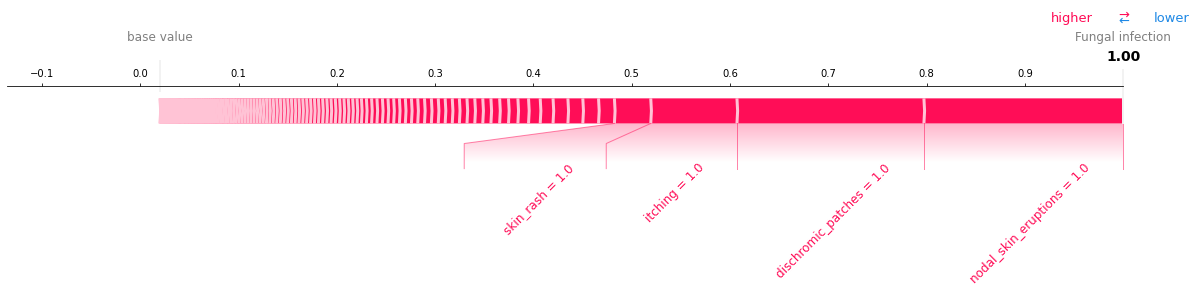

Model trained on Unduplicated Data


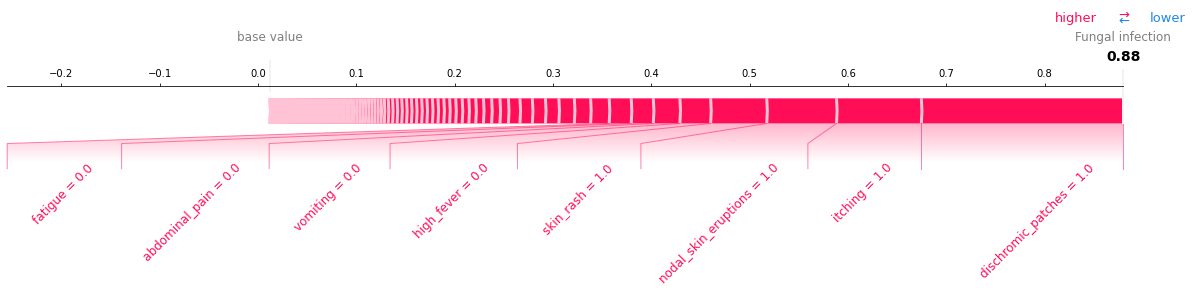

Model trained on Generated Data


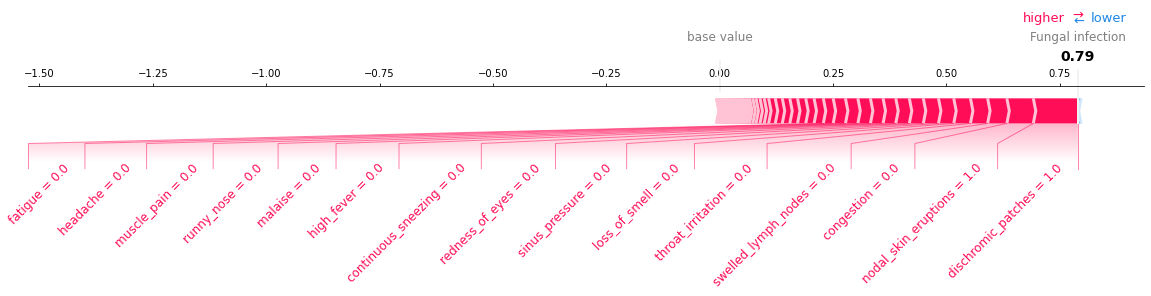

============================== Allergy ==============================
Model trained on Original Data


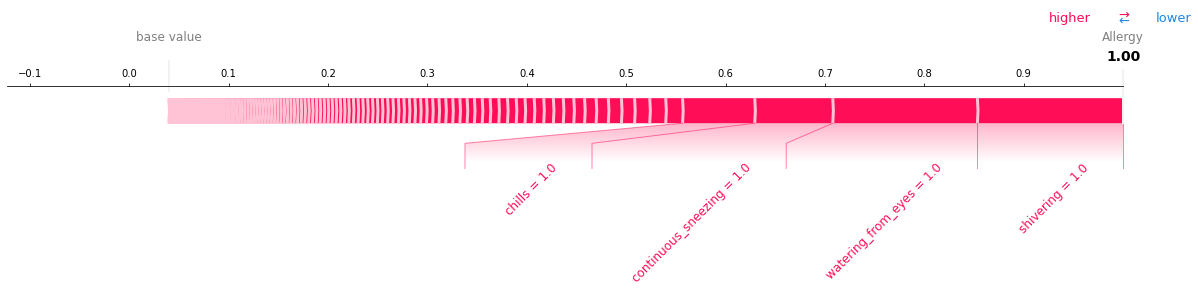

Model trained on Unduplicated Data


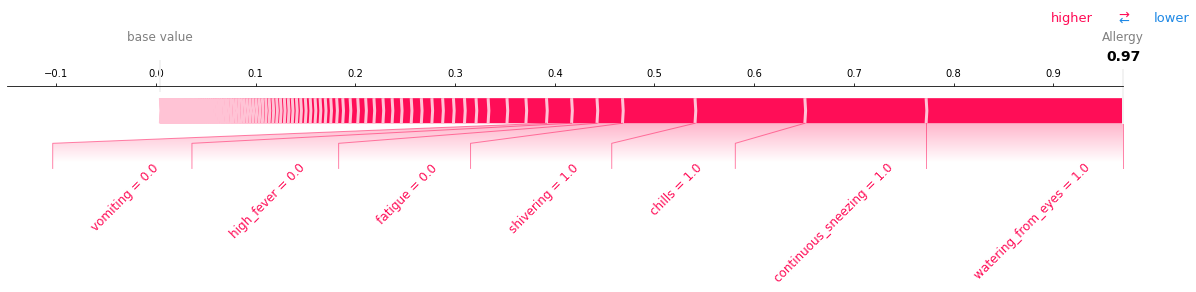

Model trained on Generated Data


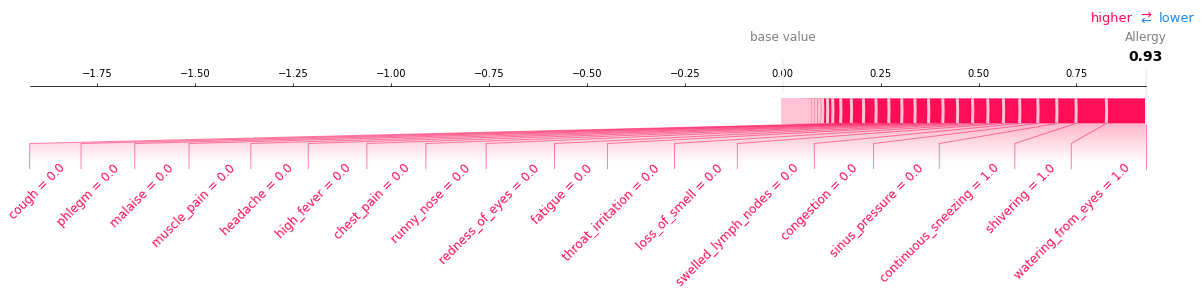

============================== GERD ==============================
Model trained on Original Data


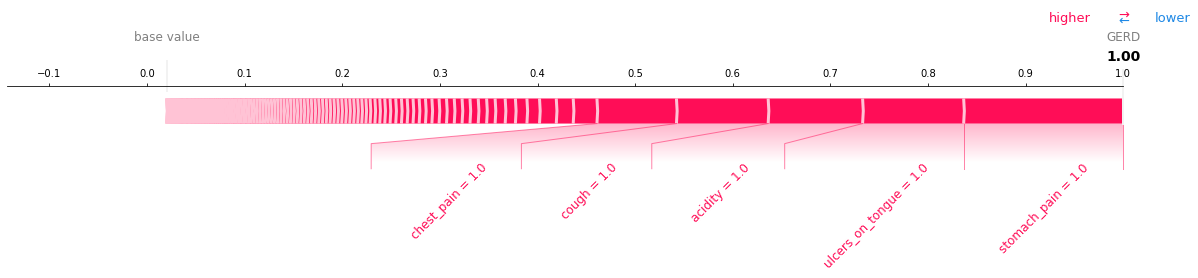

Model trained on Unduplicated Data


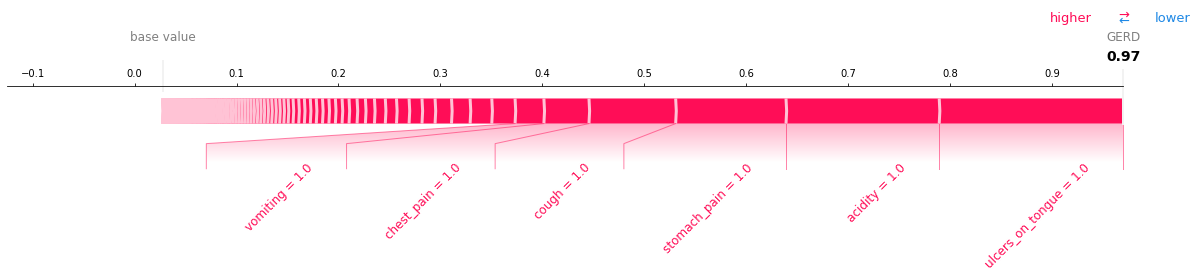

Model trained on Generated Data


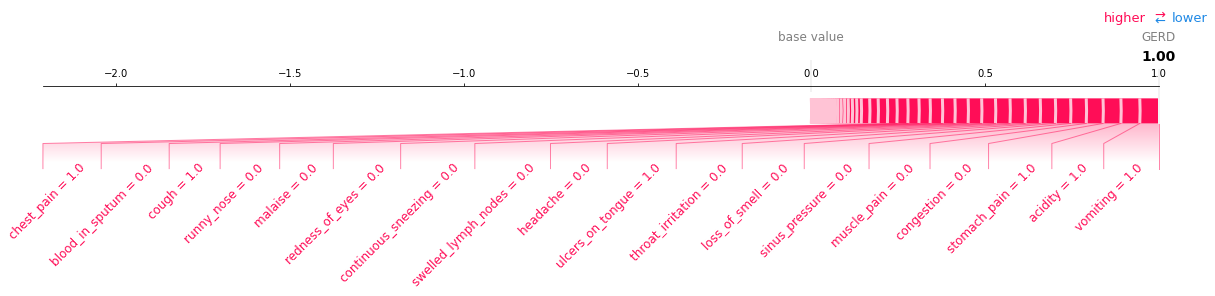

============================== Chronic cholestasis ==============================
Model trained on Original Data


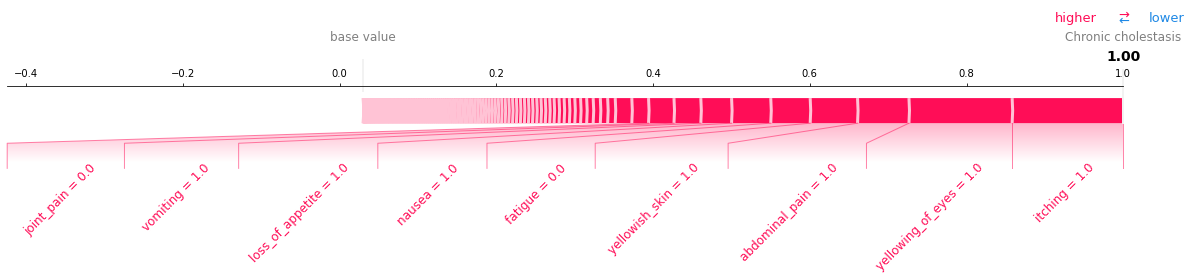

Model trained on Unduplicated Data


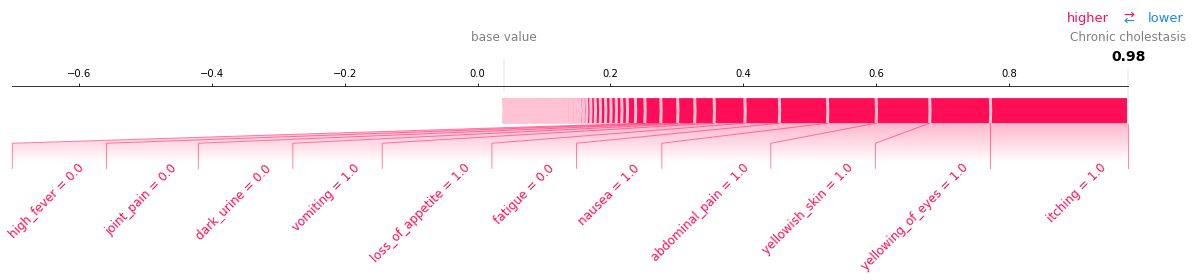

Model trained on Generated Data


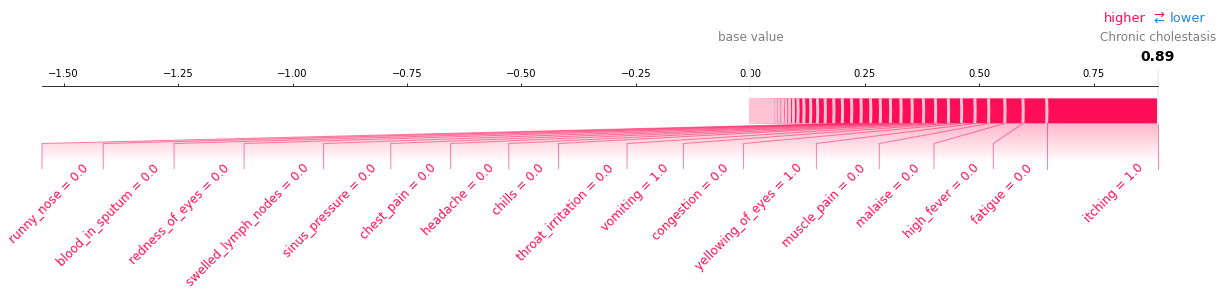

In [121]:
compare_force_plots(sample_number=0)
compare_force_plots(sample_number=1)
compare_force_plots(sample_number=2)
compare_force_plots(sample_number=3)

### Validating the three models with average confidence of 205 unbiased samples

In [122]:
# Sampling 205 unbiased cases (Drawing 5 samples from each disease)
sampled_cases = pd.DataFrame()
for disease in unduplicated_data['disease'].unique():
  sampled_cases=sampled_cases.append(unduplicated_data[unduplicated_data['disease']==disease].sample(5))

In [123]:
# Function to calculate Average Confidence of a number of samples for a particular model
def find_avg_confidence(sampled_cases, model):
  avg_confidence = 0
  for disease, prediction in zip(sampled_cases.disease, model.predict_proba(sampled_cases.drop(columns='disease'))):
    avg_confidence += prediction[np.where(model.classes_ == disease)[0][0]]
  avg_confidence/=205
  return avg_confidence

In [130]:
print("Average confidence of model trained on Original Data: ",find_avg_confidence(sampled_cases, rfc_original))
print("Average confidence of model trained on Unduplicated Original Data: ",find_avg_confidence(sampled_cases, rfc_undup))
print("Average confidence of model trained on Generated Data: ",find_avg_confidence(sampled_cases, rfc_generated))

Average confidence of model trained on Original Data:  0.99790243902439
Average confidence of model trained on Unduplicated Original Data:  0.8703414634146343
Average confidence of model trained on Generated Data:  0.9491256678281069
